In [3]:
import docplex.mp
import cplex
import pandas as pd
from pandas import DataFrame

Read in data on securities: activity sector, expected return rate, and whether or not activity is based in North America.

In [4]:
sec_data = {
    'sector': ['treasury', 'hardware', 'theater', 'telecom', 'brewery', 'highways', 'cars', 'bank', 'software',
               'electronics'],
    'return': [5, 17, 26, 12, 8, 9, 7, 6, 31, 21],
    'area': ['N-Am.', 'N-Am.', 'N-Am.', 'N-Am.', "ww", 'ww', 'ww', 'ww', 'ww', 'ww']
}

df_secs = DataFrame(sec_data, columns=['sector', 'return', 'area'])
df_secs.set_index(['sector'], inplace=True)


securities = df_secs.index
df_secs

,return,area
sector,,
treasury,5,N-Am.
hardware,17,N-Am.
theater,26,N-Am.
telecom,12,N-Am.
brewery,8,ww
highways,9,ww
cars,7,ww
bank,6,ww
software,31,ww


**The Covariance Matrix**

Covariance matrix is a square matrix (its size is the number of shares). The covariance matrix is also stored in a pandas DataFrame.

In [5]:
# the variance matrix
var = {
    "treasury": [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "hardware": [0, 19, -2, 4, 1, 1, 1, 0.5, 10, 5],
    "theater": [0, -2, 28, 1, 2, 1, 1, 0, -2, -1],
    "telecom": [0, 4, 1, 22, 0, 1, 2, 0, 3, 4],
    "brewery": [0, 1, 2, 0, 4, -1.5, -2, -1, 1, 1],
    "highways": [0, 1, 1, 1, -1.5, 3.5, 2, 0.5, 1, 1.5],
    "cars": [0, 1, 1, 2, -2, 2, 5, 0.5, 1, 2.5],
    "bank": [0, 0.5, 0, 0, -1, 0.5, 0.5, 1, 0.5, 0.5],
    "software": [0, 10, -2, 3, 1, 1, 1, 0.5, 25, 8],
    "electronics": [0, 5, -1, 4, 1, 1.5, 2.5, 0.5, 8, 16]
}

dfv = pd.DataFrame(var, index=securities, columns=securities)
dfv

sector,treasury,hardware,theater,telecom,brewery,highways,cars,bank,software,electronics
sector,,,,,,,,,,
treasury,0.1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
hardware,0.0,19.0,-2,4,1.0,1.0,1.0,0.5,10.0,5.0
theater,0.0,-2.0,28,1,2.0,1.0,1.0,0.0,-2.0,-1.0
telecom,0.0,4.0,1,22,0.0,1.0,2.0,0.0,3.0,4.0
brewery,0.0,1.0,2,0,4.0,-1.5,-2.0,-1.0,1.0,1.0
highways,0.0,1.0,1,1,-1.5,3.5,2.0,0.5,1.0,1.5
cars,0.0,1.0,1,2,-2.0,2.0,5.0,0.5,1.0,2.5
bank,0.0,0.5,0,0,-1.0,0.5,0.5,1.0,0.5,0.5
software,0.0,10.0,-2,3,1.0,1.0,1.0,0.5,25.0,8.0


There is a constraint that the total fraction of wealth invested in North American securities must be greater than some minimum value. To implement this constraint, we add a new column to df_secs, that is equal to 1 if and only if the area column equals "N.-Am.", else is equal to 0 (see later how we use this column to implemen the constraint).

In [6]:
def is_nam(s):
    return 1 if s == 'N-Am.' else 0

df_secs['is_na'] = df_secs['area'].apply(is_nam)
df_secs

,return,area,is_na
sector,,,
treasury,5,N-Am.,1
hardware,17,N-Am.,1
theater,26,N-Am.,1
telecom,12,N-Am.,1
brewery,8,ww,0
highways,9,ww,0
cars,7,ww,0
bank,6,ww,0
software,31,ww,0


In [8]:
from docplex.mp.model import Model

mdl = Model(name='portfolio_miqp')

In [9]:
# create variables
df_secs['frac'] = mdl.continuous_var_list(securities, name='frac', ub=1)


Express the business constraints

The business constraints are the following:

   - the sum of allocated fractions equal 100%
   - each security cannot exceed a certain percentage of the initial allocated wealth (here 30%)
   - there must be at least 40% of wealth invested in securities hosted in North America
   - compound return on investment must be less than or equal to a minimum target (say 9%)



In [10]:
# max fraction
frac_max = 0.3
for row in df_secs.itertuples():
    mdl.add_constraint(row.frac <= 0.3)
    
# sum of fractions equal 100%
mdl.add_constraint(mdl.sum(df_secs.frac) == 1)

# north america constraint:
#    - add a 1-0 column equal to 1 
# compute the scalar product of frac variables and the 1-0 'is_na' column and set a minimum
mdl.add_constraint(mdl.dot(df_secs.frac, df_secs.is_na) >= .4)

# ensure minimal return on investment
target_return = 9 # return data is expressed in percents
# again we use scalar product to compute compound return rate
# keep the expression to use as a kpi.
actual_return = mdl.dot(df_secs.frac, df_secs['return'])
mdl.add_kpi(actual_return, 'ROI')

# keep the constraint for later use (more on this later)
ct_return = mdl.add_constraint(actual_return >= 9)

**Express the objective**

The objective or goal is to minimize risk, here computed as the variance of the allocation, given a minimum return rate is guaranteed. Variance is computed as a quadratic expression, which makes this model a Quadratic Programming (QP) model


In [11]:
# KPIs
fracs = df_secs.frac
variance = mdl.sum(float(dfv[sec1][sec2]) * fracs[sec1] * fracs[sec2] for sec1 in securities for sec2 in securities)
mdl.add_kpi(variance, 'Variance')

# finally the objective
mdl.minimize(variance)

Solve the model

If you're using a Community Edition of CPLEX runtimes, depending on the size of the problem, the solve stage may fail and will need a paying subscription or product installation.

We display the objective and KPI values after the solve by calling the method report() on the model.


In [13]:
assert mdl.solve(), "Solve failed"
mdl.report()

* model portfolio_miqp solved with objective = 0.406
*  KPI: ROI      = 9.000
*  KPI: Variance = 0.406


The model has solved with a target return of 9% and a variance of 0.406.

In [14]:
all_fracs = {}
for row in df_secs.itertuples():
    pct = 100 * row.frac.solution_value
    all_fracs[row[0]] = pct
    print('-- fraction allocated in: {0:<12}: {1:.2f}%'.format(row[0], pct))

-- fraction allocated in: treasury    : 30.00%
-- fraction allocated in: hardware    : 2.08%
-- fraction allocated in: theater     : 5.46%
-- fraction allocated in: telecom     : 2.46%
-- fraction allocated in: brewery     : 15.35%
-- fraction allocated in: highways    : 8.60%
-- fraction allocated in: cars        : 1.61%
-- fraction allocated in: bank        : 29.00%
-- fraction allocated in: software    : 4.34%
-- fraction allocated in: electronics : 1.10%


Let's display these fractions in a pie chart using the Python package matplotlib.

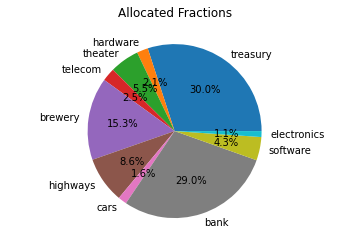

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

def display_pie(pie_values, pie_labels, colors=None,title=''):
    plt.axis("equal")
    plt.pie(pie_values, labels=pie_labels, colors=colors, autopct="%1.1f%%")
    plt.title(title)
    plt.show()
                                                           
display_pie( list(all_fracs.values()), list(all_fracs),title='Allocated Fractions')